In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Question 1 - NPV Breakeven with Demand Forecasting and Monte Carlo

In this problem, we will examine how uncertainty in demand and variables related to production affect the profitability of a project.

__Q1.1__

Below, create a function that intakes the variables related and returns the number of units required for NPV breakeven. Apply your function npv_breakeven to the following problem (taken from Leeds slide 252): 

"A machine costs \\$100K and will last ten years. It will produce a product that will sell for \\$50 per unit. The product will have a variable cost of \\$10 per unit and fixed costs of \\$20K per year. The machine will be depreciated using straight line depreciation with no salvage value. The cost of capital is 10%. The tax rate is 25%. Find the units required for NPV breakeven."

In [158]:
from numpy import npv, fv, pv, rate, pmt

def npv_breakeven(item_cost, sale_price, var_cost, fixed_cost, depreciation, tax_rate, cost_of_capital, n_periods):
    CF = -pmt(rate = cost_of_capital, pv = item_cost, nper = n_periods) 
    units = ((CF - depreciation)/(1 - tax_rate) + depreciation + fixed_cost)/(sale_price - var_cost)
    
    return units

In [19]:
npv_breakeven(item_cost = 100000, 
              sale_price = 50, 
              var_cost = 10,
              fixed_cost = 20000,
              depreciation = 10000,
              tax_rate = .25,
              cost_of_capital = .1,
              n_periods = 10)

959.1513162750383

__Q1.2__

In this scenario we will assume all variables with the exception of sales price are fixed. Using the npv_breakeven function you created above, find the number of units required for NPV breakeven as the sales price fluctuates anywhere between \\$20 and \\$80. (Use a step size that at minimum checks each dollar amount.) Plot your results, with the x-axis as the sales price and the y-axis as the required number of units.

In [59]:
breakeven = []

for sales_price in np.linspace(20, 80, 49):
    units = npv_breakeven(item_cost = 100000, 
              sale_price = sales_price, 
              var_cost = 10,
              fixed_cost = 20000,
              depreciation = 10000,
              tax_rate = .25,
              cost_of_capital = .1,
              n_periods = 10)
    
    breakeven.append((sales_price, units))

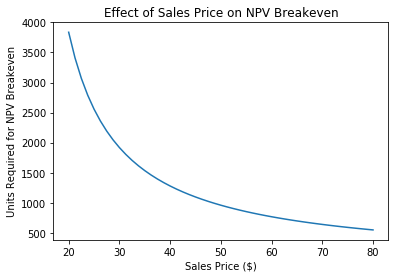

In [64]:
plt.plot(*zip(*breakeven))
plt.xlabel('Sales Price ($)')
plt.ylabel('Units Required for NPV Breakeven')
plt.title('Effect of Sales Price on NPV Breakeven')
plt.show()

__Q1.3__

Now, we would like to incorporate demand information into our decision to pursue this project. We will start first with the assumption based on a naive forecast with an amount of randomly distributed noise. 

We'll assume for the moment that our units demand comes from a normal distribution with a mean of 925 and standard deviation of 100. Using this assumption and our original sales price of \\$50 generate 10,000 samples of potential cashflows and calculate the NPV of each. Plot the results as a histogram, and report with what probability we find a negative NPV and what probability we have a positive NPV.  

In [66]:
from numpy.random import normal

In [178]:
def breakeven_cashflow(units, sale_price, var_cost, fixed_cost, depreciation, tax_rate):
    CF = (sale_price*units - var_cost*units - fixed_cost - depreciation)*(1 - tax_rate) + depreciation
    return CF

In [200]:
simulated_npv = []

for simulation in range(10000):
    units = [normal(925, 100) for i in range(10)]

    cashflows = [-100000] + [breakeven_cashflow(units = units_demanded, 
                                                sale_price = 50, 
                                                var_cost = 10, 
                                                fixed_cost = 20000, 
                                                depreciation = 10000, 
                                                tax_rate = .25) for units_demanded in units]
    
    trial_npv = npv(rate = .1, values = cashflows)
    
    simulated_npv.append(trial_npv)

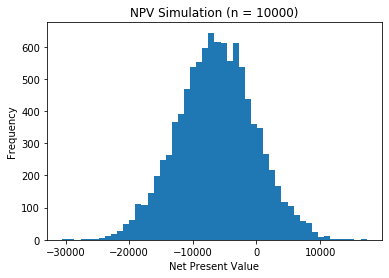

In [201]:
plt.hist(simulated_npv, bins = 50)
plt.title('NPV Simulation (n = 10000)')
plt.ylabel('Frequency')
plt.xlabel('Net Present Value')
plt.show()

In [202]:
print("Probability of Positive NPV:", len([npv for npv in simulated_npv if npv > 0])/len(simulated_npv))
print("Probability of Negative NPV:", len([npv for npv in simulated_npv if npv < 0])/len(simulated_npv))

Probability of Positive NPV: 0.1499
Probability of Negative NPV: 0.8501


__Q1.4 (Conceptual)__

Though our point estimate in the last question was only a small amount below the cutoff for breakeven NPV, we see poor performance overall. Conceptually, what would our point estimate need to be to insure a positive NPV half of the time? How would this be affected if the error in our demand estimate were not normal?

Answer: 

If our point estimate of demand were the NPV Breakeven and the actual units demanded is normally distributed, on average half the time we should have positive NPV. 

If our errors are not normally distributed, wthey could be coming from a distribution with a high skew or excess kurtosis. This could mean that even if our estimate were exactly at the NPV breakeven, we could still have a much larger change of negative NPV than might be expected. 

__Q1.5__

Suppose that we were relatively risk averse and required a probability of at least 80% positive NPV. Using the same method as above what would the cutoff be for our point estimate of demand? Assume that the standard deviation remains at 100 units. Find this by varying the point estimate for demand with 10,000 simulations for each point estimate. Use a step size of 5 units in your search, testing anywhere from 900 to 1000 as our inital estimate of units demanded.

In [219]:
probabilities = []

for point_estimate in range(900, 1001, 5):
    simulated_npv = []

    for simulation in range(10000):
        units = [normal(point_estimate, 100) for i in range(10)]

        cashflows = [-100000] + [breakeven_cashflow(units = units_demanded, 
                                                    sale_price = 50, 
                                                    var_cost = 10, 
                                                    fixed_cost = 20000, 
                                                    depreciation = 10000, 
                                                    tax_rate = .25) for units_demanded in units]

        trial_npv = npv(rate = .1, values = cashflows)

        simulated_npv.append(trial_npv)

    probability_positive = len([npv for npv in simulated_npv if npv > 0])/len(simulated_npv)
    probabilities.append((point_estimate, probability_positive))

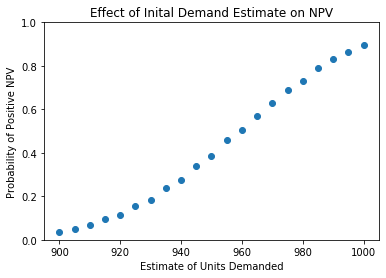

In [224]:
plt.scatter(*zip(*probabilities))
plt.ylim(0, 1)
plt.xlabel('Estimate of Units Demanded')
plt.ylabel('Probability of Positive NPV')
plt.title('Effect of Inital Demand Estimate on NPV')
plt.show()

In [253]:
from operator import itemgetter
min([prob for prob in probabilities if prob[1] > .8], key = itemgetter(1))

(990, 0.8306)

__Conceptual: What does the concavity and inflection point represent?__

Answer:

The inflection point occurs at the units required for NPV breakeven. Up to this point we have positive concavity and past it we have negative concavity. In terms of interpretation, this means that once we pass the point of units required for NPV breakeven, we see diminishing returns how much each additional unit demanded increases our probability of positive NPV.

__Q1.6__

Next, we would like to see the tradeoff between varying our estimate of units demanded and our sales price. For the sake of computation time, we will look at a small strip of values. For each combination of price (use \\$40-\\$60) and units demanded (use 700-1400), calulate the NPV for a simulation with 10000 iterations. Plot the results as a scatter plot, where the x-axis is the estimate of units demanded, the y-axis is the sale price, and the color represents the probability of a positive NPV

In [304]:
from itertools import product

In [378]:
price_demand_combinations = list(product(np.linspace(40, 60, 21), range(700, 1401, 25)))
#price_demand_combinations = list(product(np.linspace(49, 51, 21), range(900, 1000, 5)))

In [379]:
len(price_demand_combinations)

609

In [380]:
%%time
grid = []
grid_probabilities = []

for combination in price_demand_combinations:
    simulated_npv = []

    for simulation in range(10000):
        units = [normal(combination[1], 100) for i in range(10)]

        cashflows = [-100000] + [breakeven_cashflow(units = units_demanded, 
                                                    sale_price = combination[0], 
                                                    var_cost = 10, 
                                                    fixed_cost = 20000, 
                                                    depreciation = 10000, 
                                                    tax_rate = .25) for units_demanded in units]

        trial_npv = npv(rate = .1, values = cashflows)

        simulated_npv.append(trial_npv)

    probability_positive = len([npv for npv in simulated_npv if npv > 0])/len(simulated_npv)
    
    grid.append((combination[0], combination[1]))
    grid_probabilities.append(probability_positive)

Wall time: 4min 2s


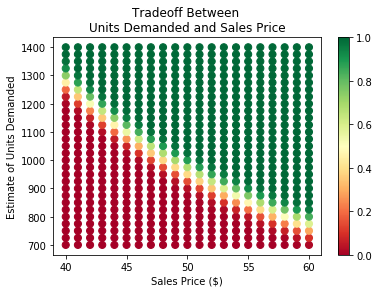

In [394]:
color_map = plt.cm.get_cmap('RdYlGn')
plt.scatter(*zip(*grid), c = grid_probabilities, s = 50, cmap=color_map)
plt.xlabel('Sales Price ($)')
plt.ylabel('Estimate of Units Demanded')
plt.title('Tradeoff Between \nUnits Demanded and Sales Price')
plt.colorbar()
plt.show()

# End of Completed Questions (working on generating a historical dataset that matches the question)

Q1.7

The above analysis used the naive forecast, simply one estimate of our best guess of units demanded. Now we will incorporate a demand forecast. Suppose that we have several years of historical data on another product that we believe is a close substitue, given on a monthly basis. This data is read in below. Use the last ten months as a validation set and the remaining as the training set. Tune an XGBoosting model and then forecast forward another then months to  

In [257]:
import xgboost as xgb

In [299]:
x = np.linspace(0, 2*np.pi, 60)
historical_demand = 50*np.sin(5*np.linspace(0, 2*np.pi, 60))+950
historical_demand = [demand + normal(0, 5) for demand in historical_demand]

historical_demand 

[951.3657745778721,
 982.0350430824942,
 1005.4260730368857,
 995.1329108067044,
 991.9401503301751,
 975.9037732428307,
 937.2861858935049,
 927.9231306201875,
 899.7787860619649,
 905.9300451553102,
 906.3383577716954,
 930.4214055970755,
 959.3273442340065,
 972.7164602408573,
 992.8524947616129,
 1000.2002054062003,
 989.8539360599829,
 971.8967901231474,
 946.2904135926589,
 912.0579064447302,
 905.1309101114545,
 898.6746093853134,
 903.8519972992656,
 937.5581482866182,
 959.1957680881218,
 980.952670179297,
 992.928475679548,
 1001.3515160900728,
 988.9181323464029,
 956.9474097145613,
 929.8116122636246,
 908.4283635179385,
 894.5548548782493,
 899.7327313799954,
 914.4232894640407,
 948.1288069916608,
 965.9510392196125,
 979.7820309016867,
 994.2159977199778,
 990.912762767043,
 973.65740431932,
 964.2857364842391,
 932.4901193870732,
 914.5191336254532,
 908.5941849713121,
 897.5389928703889,
 926.1413441792073,
 939.1789696378872,
 968.8275095293209,
 987.3831477372956,
 1

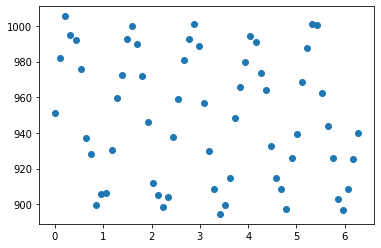

In [301]:
plt.scatter(x, historical_demand)
plt.show()

This data makes sense to be monthly, but I've made the above problem yearly. Forecast and aggregate?